### IRIS AIA comparisons via space-time-plot
This script provides an example of how to use previously downloaded AIA data (e.g. using `Sunpy.net.Fido` `search` and `fetch`) to generate a plot of the AIA image at the position of the IRIS slit over the time of an IRIS Observation.

inputs:
- AIA images (here we use 304) during an IRIS observation
- coordinates of IRIS slit at the beginning of the observartion

In [1]:
import os
import glob
import numpy as np

import sunpy.map
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import sunpy.visualization.colormaps as cm
from astropy import units as u

import aiapy
from aiapy.calibrate import update_pointing
from aiapy.calibrate.prep import register as aiaprep 

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# inputs
aia_folder = '../../../../_testdata/aia304_20130830_full'
p1_x1, p1_y1, p2_x2, p2_y2 = 1162, 1963, 1163, 1763

In [4]:
# processing hundreds of files will take a while...  for the sake of the demo we limit to 400 files
# if you have the saved numpy arrays available, load them in the cell below instead

files = glob.glob(aia_folder + "/*")[0:400]

# get coordinates of slit-line
gradient = (p2_y2-p1_y1)/(p2_x2-p1_x1)
origin = p1_y1 - gradient * p1_x1
y = np.arange(min(p1_y1, p2_y2),max(p1_y1, p2_y2)+1)
x = (y - origin) / gradient
coords = (np.column_stack((x.round().astype(int),y.astype(int))))

# get pointing table for pre-processing
aia0_map = sunpy.map.Map(files[0])
aiaN_map = sunpy.map.Map(files[-1])
pt = aiapy.calibrate.util.get_pointing_table(aia0_map.date - 12*u.h, aiaN_map.date + 12*u.h)

# pre-process first AIA image
aia_updated_pointing_0 = aiapy.calibrate.update_pointing(aia0_map, pointing_table=pt)
aia_0 = aiaprep(aia_updated_pointing_0)
skycoords0 = aia0_map.pixel_to_world(coords[:,0] * u.pix, coords[:,1] * u.pix)

# get AIA pixels at IRIS slit
final_image = []
list_dates = []
ndiv10 = len(files) // 10
for i in range(0,len(files)-1):
    # print progress since this might take a while
    if i%ndiv10 == 0:
        print(i//ndiv10, end='0%, ')

    try:         
        aia_i_map = sunpy.map.Map(files[i])
    except:
        print(f"\nskipped file: {i} ({files[i]}) - failed to load AIA map")
        continue

    # pre-process current AIA image
    aia_updated_pointing_i = aiapy.calibrate.update_pointing(aia_i_map, pointing_table=pt)
    aia_i = aiaprep(aia_updated_pointing_i)

    # correct for solar diff rotation and transform back to pixel coordinates
    skycoords_i = solar_rotate_coordinate(skycoords0, time=(aia_i.date - aia_0.date).to(u.s))
    pxcoords_i = aia_i_map.world_to_pixel(skycoords_i) 
    coords_x = pxcoords_i.x.value
    coords_y = pxcoords_i.y.value.round().astype('int')
    
    # interpolate pixels of x-coordinates
    x_floor_coords = [coords_y, np.floor(coords_x).astype(int)] 
    x_ceil_coords = [coords_y, np.ceil(coords_x).astype(int)] 
    x_mod = coords_x % 1
    zi1 = np.flipud(aia_i.data**0.4)[tuple(x_floor_coords)]
    zi2 = np.flipud(aia_i.data**0.4)[tuple(x_ceil_coords)]
    zi = zi1 * (1 - x_mod) + zi2 * x_mod
    
    # divide by exposure time
    zi /= aia_i.exposure_time.value

    # update image and date-list
    if len(final_image) == 0: 
        final_image = zi 
    else:
        final_image = np.vstack([final_image, zi])
    
    list_dates.append(aia_i.date.isot.split("T")[1])
data = np.array(final_image)
time_axis = np.array(list_dates)

00%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 

In [ ]:
# save as npy arrays
np.save("../final_data/aia_data/20130830_data" , final_image)
np.save("../final_data/aia_times/20130830_time" , list_dates)

In [ ]:
# load from npy arrays
data = np.load("../final_data/aia_times/20130830_data.npy")
time_axis = np.load("../final_data/aia_times/20130830_time.npy")

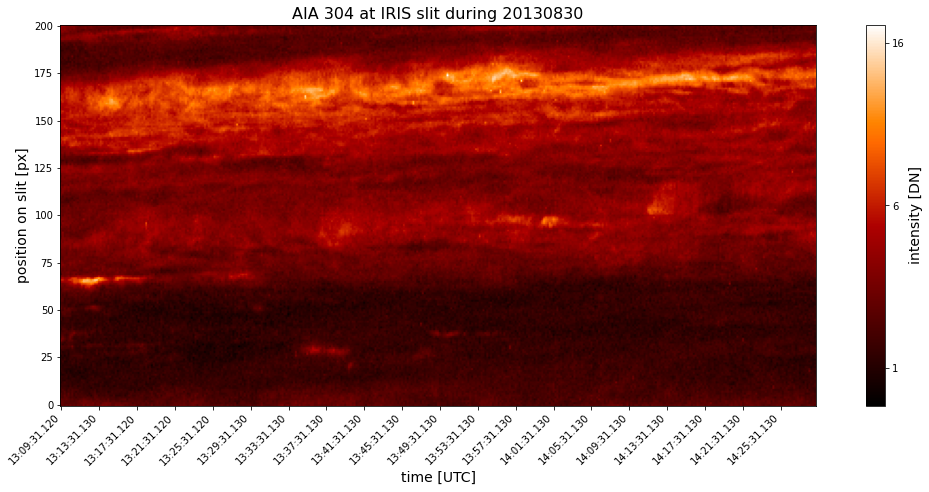

In [9]:
plt.rcParams.update({'figure.autolayout': False})
cmap = plt.get_cmap('sdoaia304')

plt.figure(figsize=(18,7))
xticks_every = 20  # put an x-tick every n pixels

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax = plt.gca()
plt.imshow(np.flipud(data.T), cmap=cmap, aspect="equal", origin="lower")
plt.xticks(np.arange(0,len(time_axis),xticks_every), time_axis[::xticks_every], rotation=45, horizontalalignment="right")
cbar = plt.colorbar()

cb_ticks = np.arange(np.ceil(data.min()), data.max())
cbar.set_ticks(cb_ticks)
cbar.set_ticklabels((cb_ticks**2.5).round().astype(np.int32))
cbar.set_label("intensity [DN]")  # cbar.set_label("$intensity^{0.4}$")

ax.set_xlabel("time [UTC]")
ax.set_ylabel("position on slit [px]")
_ = plt.title("AIA 304 at IRIS slit during 20130830")

#### Save raw image
If you need the raw pixel image, matplotlib may not be ideal.

In [ ]:
from PIL import Image

im = data.T - data.min()
im = im / im.max()
im = cm(im)

i = Image.fromarray((im[:,:,0:3]*255).astype(np.uint8))
i.save(r"..\PIL.png")

### Context plot
In addition we draw the context of where the slit is at the beginning, middle and end of the observation  
We re-use the `coords` from the cell above.

In [6]:
# get data and solar diff rotation coordinates
aia_1 = aiaprep(sunpy.map.Map(files[0]))
aia_2 = aiaprep(sunpy.map.Map(files[len(files) // 2]))
aia_3 = aiaprep(sunpy.map.Map(files[-1]))

skycoords = aia_1.pixel_to_world(coords[:,0] * u.pix, coords[:,1] * u.pix)

skycoords2 = solar_rotate_coordinate(skycoords, time=(aia_2.date - aia_1.date).to(u.s))
pxcoords_2 = aia_2.world_to_pixel(skycoords2)
coords2 = np.column_stack((pxcoords_2.x.value.round().astype(np.int),pxcoords_2.y.value.round().astype(np.int)))

skycoords3 = solar_rotate_coordinate(skycoords, time=(aia_3.date - aia_2.date).to(u.s))
pxcoords_3 = aia_3.world_to_pixel(skycoords3)
coords3 = np.column_stack((pxcoords_3.x.value.round().astype(np.int),pxcoords_3.y.value.round().astype(np.int)))

def get_context_image(aia_data, px_coords, n_px=200):
    im = np.clip(aia_data, 0, aia_data.max())  # clip negative values, which are "outside" the disc / corona
    im = im**0.4  # gamma correction
    im = np.flipud(im)
    im[px_coords[:,1], px_coords[:,0]] = im.max()  # make slit white
    M = px_coords.mean(axis=0).astype(np.int)
    im = im[M[1]-n_px:M[1]+n_px,M[0]-n_px:M[0]+n_px]
    return im

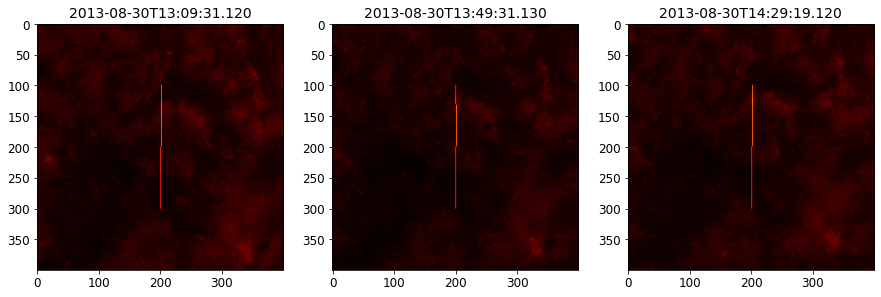

In [7]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(15,8))
plt.subplot(1, 3, 1)
im = get_context_image(aia_1.data, coords)
plt.imshow(im, cmap=aia_1.cmap, vmax=np.percentile(im, 99.99))
plt.title(aia_1.date.isot)

plt.subplot(1, 3, 2)
im = get_context_image(aia_2.data, coords2)
plt.imshow(im, cmap=aia_2.cmap, vmax=np.percentile(im, 99.99))
plt.title(aia_2.date.isot)

plt.subplot(1, 3, 3)
im = get_context_image(aia_3.data, coords3)
plt.imshow(im, cmap=aia_3.cmap, vmax=np.percentile(im, 99.99))
_ = plt.title(aia_3.date.isot)